In [13]:
import os
import warnings
import requests
import librosa
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.models import Span, LinearColorMapper, ColorBar, FixedTicker

# Initialize Bokeh for notebook output
output_notebook()

def download_audio(audio_url: str, local_path: str):
    """Download audio file from a URL to a local path."""
    if not os.path.exists(local_path):
        print(f"Downloading audio from {audio_url}...")
        response = requests.get(audio_url)
        response.raise_for_status()  # Raise an error for bad status
        with open(local_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded audio to {local_path}.")
    else:
        print(f"Audio file {local_path} already exists. Skipping download.")

def load_cuepoints(url: str, name: str, color: str):
    """Load cuepoints from a CSV file."""
    try:
        df = pd.read_csv(url)
        peaks_in_sec = df['onset_times'].values
        return {'name': name, 'times': peaks_in_sec, 'color': color}
    except Exception as e:
        warnings.warn(f"Failed to load cuepoints from {url}: {e}")
        return None

def extract_features(y_segment: np.ndarray, sr: int, hop_length: int):
    """Extract various audio features from a segment."""
    features = {}
    features['amplitude_envelope'] = librosa.onset.onset_strength(y=y_segment, sr=sr, hop_length=hop_length)
    S = librosa.feature.melspectrogram(y=y_segment, sr=sr, hop_length=hop_length)
    features['melspectrogram'] = S
    features['spectral_flux'] = np.diff(S, axis=1)
    features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y_segment, hop_length=hop_length)[0]
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=y_segment, sr=sr, hop_length=hop_length)[0]
    return features

def create_time_axis(num_frames: int, sr: int, hop_length: int, start_time: float):
    """Create a time axis for plotting."""
    return librosa.frames_to_time(np.arange(num_frames), sr=sr, hop_length=hop_length) + start_time

def plot_feature(feature_name: str, feature_data: np.ndarray, times: np.ndarray, title: str, y_label: str, width=900, height=300):
    """Create a Bokeh figure for a specific audio feature without legends."""
    p = figure(title=title, x_axis_label='Time (s)', y_axis_label=y_label, width=width, height=height)
    p.line(times, feature_data, line_width=2)
    return p

def plot_spectrogram(mel_db: np.ndarray, times: np.ndarray, sr: int, hop_length: int, start_time: float, title: str, y_label: str, width=900, height=600):
    """Create a Bokeh figure for the Mel-spectrogram."""
    p = figure(title=title, x_axis_label='Time (s)', y_axis_label=y_label, width=width, height=height)

    color_mapper = LinearColorMapper(palette="Viridis256", low=np.min(mel_db), high=np.max(mel_db))

    p.image(image=[mel_db],
            x=times[0],
            y=0,
            dw=times[-1] - times[0],
            dh=mel_db.shape[0],
            color_mapper=color_mapper)

    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0, 0), title='dB')
    p.add_layout(color_bar, 'right')

    mel_frequencies = librosa.mel_frequencies(n_mels=mel_db.shape[0], fmin=0, fmax=sr/2)
    tick_positions = np.linspace(0, mel_db.shape[0]-1, num=10, dtype=int)
    tick_labels = [f"{freq:.1f}" for freq in mel_frequencies[tick_positions]]

    p.yaxis.ticker = FixedTicker(ticks=tick_positions.tolist())
    p.yaxis.major_label_overrides = {int(pos): label for pos, label in zip(tick_positions, tick_labels)}

    return p

def plot_stft_spectrogram(y_segment: np.ndarray, sr: int, n_fft: int, hop_length_stft: int, y_min: int, y_max: int, start_time: float, title: str, width=900, height=600, interp_factor=0):
    """Create a Bokeh figure for the STFT spectrogram."""
    stft = librosa.stft(y=y_segment, n_fft=n_fft, hop_length=hop_length_stft)
    stft_db_full = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    freqs_full = np.linspace(0, sr / 2, num=stft_db_full.shape[0])
    freq_indices = np.where((freqs_full >= y_min) & (freqs_full <= y_max))[0]

    stft_db = stft_db_full[freq_indices, :]
    freqs = freqs_full[freq_indices]

    # Interpolation between linear and log frequencies
    linear_freqs = np.linspace(y_min, y_max, num=len(freq_indices))
    log_freqs = np.logspace(np.log10(max(y_min, 1)), np.log10(y_max), num=len(freq_indices))
    interp_freqs = (1 - interp_factor) * linear_freqs + interp_factor * log_freqs

    num_ticks = min(10, len(interp_freqs))
    tick_indices = np.linspace(0, len(interp_freqs) - 1, num=num_ticks).astype(int)
    tick_locations = interp_freqs[tick_indices]
    tick_labels = [f"{int(freq)} Hz" for freq in tick_locations]

    p = figure(title=title, x_axis_label='Time (s)', y_axis_label='Frequency (Hz)',
               width=width, height=height, y_range=(y_min, y_max))

    color_mapper = LinearColorMapper(palette="Viridis256", low=np.min(stft_db), high=np.max(stft_db))

    times_stft = librosa.frames_to_time(np.arange(stft_db.shape[1]), sr=sr, hop_length=hop_length_stft) + start_time

    p.image(image=[stft_db],
            x=times_stft[0],
            y=y_min,
            dw=times_stft[-1] - times_stft[0],
            dh=y_max - y_min,
            color_mapper=color_mapper)

    p.yaxis.ticker = FixedTicker(ticks=tick_locations.tolist())
    p.yaxis.major_label_overrides = {freq: label for freq, label in zip(tick_locations, tick_labels)}

    color_bar = ColorBar(
        color_mapper=color_mapper,
        label_standoff=12,
        location=(0, 0),
        title='dB'
    )
    p.add_layout(color_bar, 'right')

    return p

def add_custom_lines(plot, custom_intervals, duration):
    """Add custom interval lines to a plot."""
    for interval_set in custom_intervals:
        start = interval_set['start_time']
        step = interval_set['interval']
        color = interval_set.get('color', 'red')
        custom_time = start
        while custom_time < duration:
            span = Span(location=custom_time, dimension='height', line_color=color,
                        line_dash='dotted', line_width=2)
            plot.add_layout(span)
            custom_time += step

def add_cuepoints(plot, cuepoint_lists, start_time, end_time):
    """Add cuepoint lines to a plot."""
    for cuepoint in cuepoint_lists:
        cue_times = cuepoint['times']
        cue_color = cuepoint['color']
        relevant_times = cue_times[(cue_times >= start_time) & (cue_times <= end_time)]
        for cue_time in relevant_times:
            span = Span(location=cue_time, dimension='height', line_color=cue_color,
                        line_dash='dashed', line_width=2)
            plot.add_layout(span)

# Parameters
audio_url = 'https://github.com/egorpol/beat_it/raw/refs/heads/main/examples/Tekonivel_Voimamies.aif'
local_audio_path = 'Tekonivel_Voimamies.aif'
start_times = [0, 10, 20, 30, 60, 120]  # in seconds
end_times = [2, 12, 22, 32, 62, 122]    # in seconds
features_to_plot = ['amplitude_envelope', 'spectral_flux', 'stft_spectrogram'] # List of features to plot - 'amplitude_envelope', 'spectral_flux', 'zero_crossing_rate', 'spectral_centroid', 'melspectrogram', 'stft_spectrogram'
lines_to_plot = ['custom_interval_lines']  # Added 'cuepoints' if needed

# Define custom interval lines as a list of dictionaries
custom_intervals = [
    {'start_time': 10.031, 'interval': 0.4451, 'color': 'red'},
    # Add more custom intervals here if needed
    {'start_time': 0.6905, 'interval': 0.5563, 'color': 'orange'},
]

# STFT parameters
window_size = 1024
overlap = 0.5
hop_length_stft = int(window_size * (1 - overlap))
n_fft = window_size
y_min = 0
y_max = 10000

# Download audio
download_audio(audio_url, local_audio_path)

# Load audio
y, sr = librosa.load(local_audio_path)
duration = len(y) / sr
print(f"The audio file is {duration:.2f} seconds long.")

# Validate segment times
if len(start_times) != len(end_times):
    raise ValueError("start_times and end_times must be lists of the same length.")

# Load cuepoint lists
cuepoint_urls = [
    {
        'url': 'https://raw.githubusercontent.com/egorpol/beat_it/refs/heads/main/csv/dufour_onsets_librosa_unfiltered.csv',
        'name': 'Onsets Unfiltered',
        'color': 'orange'
    },
    # Add more cuepoint URLs here
    # {
    #     'url': 'https://example.com/other_cuepoints.csv',
    #     'name': 'Other Cuepoints',
    #     'color': 'green'
    # },
]

cuepoint_lists = []
for cp in cuepoint_urls:
    cuepoint = load_cuepoints(cp['url'], cp['name'], cp['color'])
    if cuepoint:
        cuepoint_lists.append(cuepoint)

# Initialize layout list
segment_layouts = []

# Process each segment
for idx, (start_time, end_time) in enumerate(zip(start_times, end_times), 1):
    if start_time < 0 or end_time > duration:
        warnings.warn(f"Segment {idx}: start_time or end_time is out of bounds. Skipping this segment.")
        continue

    # Extract segment
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    y_segment = y[start_sample:end_sample]

    # Extract features
    hop_length = 512
    features = extract_features(y_segment, sr, hop_length)

    # Create time axes
    times_amplitude = create_time_axis(len(features['amplitude_envelope']), sr, hop_length, start_time)
    times_flux = create_time_axis(features['spectral_flux'].shape[1], sr, hop_length, start_time)
    times_zcr = create_time_axis(len(features['zero_crossing_rate']), sr, hop_length, start_time)
    times_centroid = create_time_axis(len(features['spectral_centroid']), sr, hop_length, start_time)
    times_mel = create_time_axis(features['melspectrogram'].shape[1], sr, hop_length, start_time)

    # Initialize plots dictionary
    plots = {}

    # Plot amplitude envelope
    if 'amplitude_envelope' in features_to_plot:
        p_amp = plot_feature('Amplitude Envelope', features['amplitude_envelope'],
                             times_amplitude, f"Amplitude Envelope (Segment {idx})", 'Amplitude')
        plots['amplitude_envelope'] = p_amp

    # Plot spectral flux
    if 'spectral_flux' in features_to_plot:
        p_flux = figure(title=f"Spectral Flux (Segment {idx})", x_axis_label='Time (s)',
                        y_axis_label='Spectral Flux', width=900, height=300)
        for flux in features['spectral_flux']:
            p_flux.line(create_time_axis(len(flux), sr, hop_length, start_time), flux, line_width=1, color="blue")
        plots['spectral_flux'] = p_flux

    # Plot zero-crossing rate
    if 'zero_crossing_rate' in features_to_plot:
        p_zcr = plot_feature('Zero-Crossing Rate', features['zero_crossing_rate'],
                             times_zcr, f"Zero-Crossing Rate (Segment {idx})", 'Zero-Crossing Rate')
        plots['zero_crossing_rate'] = p_zcr

    # Plot spectral centroid
    if 'spectral_centroid' in features_to_plot:
        p_centroid = plot_feature('Spectral Centroid', features['spectral_centroid'],
                                  times_centroid, f"Spectral Centroid (Segment {idx})", 'Spectral Centroid (Hz)')
        plots['spectral_centroid'] = p_centroid

    # Plot Mel-spectrogram
    if 'melspectrogram' in features_to_plot:
        mel_db = librosa.power_to_db(features['melspectrogram'], ref=np.max)
        p_mel = plot_spectrogram(mel_db, times_mel, sr, hop_length, start_time,
                                 f"Mel-Spectrogram (Segment {idx})", 'Frequency (Mel)')
        plots['melspectrogram'] = p_mel

    # Plot STFT spectrogram
    if 'stft_spectrogram' in features_to_plot:
        p_stft = plot_stft_spectrogram(y_segment, sr, n_fft, hop_length_stft, y_min, y_max,
                                       start_time, f"STFT Spectrogram (Segment {idx})")
        plots['stft_spectrogram'] = p_stft

    # Add custom interval lines
    if 'custom_interval_lines' in lines_to_plot:
        for plot in plots.values():
            add_custom_lines(plot, custom_intervals, duration)

    # Add cuepoints
    if 'cuepoints' in lines_to_plot and cuepoint_lists:
        for plot in plots.values():
            add_cuepoints(plot, cuepoint_lists, start_time, end_time)

    # Combine plots into a column
    segment_layout = column(*plots.values())
    segment_layouts.append(segment_layout)

# Combine all segments into a single layout
layout = column(*segment_layouts)

# Display the layout
show(layout)


Output hidden; open in https://colab.research.google.com to view.

In [17]:
import math

# Given values
start_time_custom = 10.031  # in seconds
interval = 0.4451            # in seconds
max_time = 201              # desired maximum time in seconds

# # Given values
# start_time_custom = 0.6905  # in seconds
# interval = 0.5563            # in seconds
# max_time = 201              # desired maximum time in seconds

# Step 1: Calculate how many intervals to subtract to get closest to zero
n_intervals = math.floor(start_time_custom / interval)
base_time = start_time_custom - (n_intervals * interval)

# Handle potential negative base_time (if any)
if base_time < 0:
    n_intervals -= 1
    base_time = start_time_custom - (n_intervals * interval)

# Ensure base_time is non-negative
base_time = max(base_time, 0)

# Step 2: Generate the list from base_time to max_time with the given interval
num_steps = math.ceil((max_time - base_time) / interval) + 1  # +1 to include max_time if exact

times_list = [round(base_time + i * interval, 3) for i in range(num_steps)]

# Optional: Trim any values that exceed max_time due to floating-point arithmetic
times_list = [t for t in times_list if t <= max_time]

# Display the result
print(times_list)


[0.239, 0.684, 1.129, 1.574, 2.019, 2.464, 2.909, 3.355, 3.8, 4.245, 4.69, 5.135, 5.58, 6.025, 6.47, 6.915, 7.36, 7.806, 8.251, 8.696, 9.141, 9.586, 10.031, 10.476, 10.921, 11.366, 11.811, 12.257, 12.702, 13.147, 13.592, 14.037, 14.482, 14.927, 15.372, 15.817, 16.262, 16.707, 17.153, 17.598, 18.043, 18.488, 18.933, 19.378, 19.823, 20.268, 20.713, 21.159, 21.604, 22.049, 22.494, 22.939, 23.384, 23.829, 24.274, 24.719, 25.164, 25.61, 26.055, 26.5, 26.945, 27.39, 27.835, 28.28, 28.725, 29.17, 29.615, 30.061, 30.506, 30.951, 31.396, 31.841, 32.286, 32.731, 33.176, 33.621, 34.066, 34.511, 34.957, 35.402, 35.847, 36.292, 36.737, 37.182, 37.627, 38.072, 38.517, 38.963, 39.408, 39.853, 40.298, 40.743, 41.188, 41.633, 42.078, 42.523, 42.968, 43.413, 43.859, 44.304, 44.749, 45.194, 45.639, 46.084, 46.529, 46.974, 47.419, 47.865, 48.31, 48.755, 49.2, 49.645, 50.09, 50.535, 50.98, 51.425, 51.87, 52.316, 52.761, 53.206, 53.651, 54.096, 54.541, 54.986, 55.431, 55.876, 56.321, 56.767, 57.212, 57.657,

In [18]:
import pandas as pd

# Create a DataFrame
df_seq = pd.DataFrame({"onset_times": times_list})


# Define the file path
file_path = 'tekonivel_onsets_bassdrum_projected.csv'

# Save the DataFrame to a CSV file
df_seq.to_csv(file_path, index=False)

# Print the dynamic message
print(f"Sequence has been saved to '{file_path}'")

Sequence has been saved to 'tekonivel_onsets_bassdrum_projected.csv'


In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the onset data from two CSV files
onsets1 = pd.read_csv('https://raw.githubusercontent.com/egorpol/beat_it/refs/heads/main/csv/tekonivel_onsets_bassdrum_projected.csv')  # Assumes one column with time data
onsets2 = pd.read_csv('https://raw.githubusercontent.com/egorpol/beat_it/refs/heads/main/csv/tekonivel_onsets_synth_projected.csv')  # Assumes one column with time data

output_notebook()


# Create a figure for the plot
p = figure(title="Onset Times from Two CSV Lists",
           x_axis_label='Time (s)',
           y_axis_label='Onset Series',
           width=1000, height=600)

# Plot onsets1 as blue circles and onsets2 as red triangles using the scatter method
p.scatter(onsets1, [1]*len(onsets1), size=10, color="blue", legend_label="bdrum", marker='circle')
p.scatter(onsets2, [1]*len(onsets2), size=10, color="red", legend_label="synth", marker='triangle')

# Adjust y-axis limits to separate the two onset lists visually
p.y_range.start = 0.5
p.y_range.end = 2.5

# Show the legend
p.legend.location = "top_left"

# Display the plot
show(p)


In [29]:
onsets1.rename(columns={'bass_onset': 'onset_times'}, inplace=True)
onsets2.rename(columns={'synth_onset': 'onset_times'}, inplace=True)

onsets1['source'] = 'Bass Drum'
onsets2['source'] = 'Synth'

# Concatenate the two DataFrames
combined_onsets = pd.concat([onsets1, onsets2], ignore_index=True)

# Optional: Sort by onset time
combined_onsets.sort_values(by='onset_times', inplace=True)

# Reset index after sorting
combined_onsets.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
print(combined_onsets.head())


   onset_times     source
0        0.134      Synth
1        0.239  Bass Drum
2        0.684  Bass Drum
3        0.691      Synth
4        1.129  Bass Drum


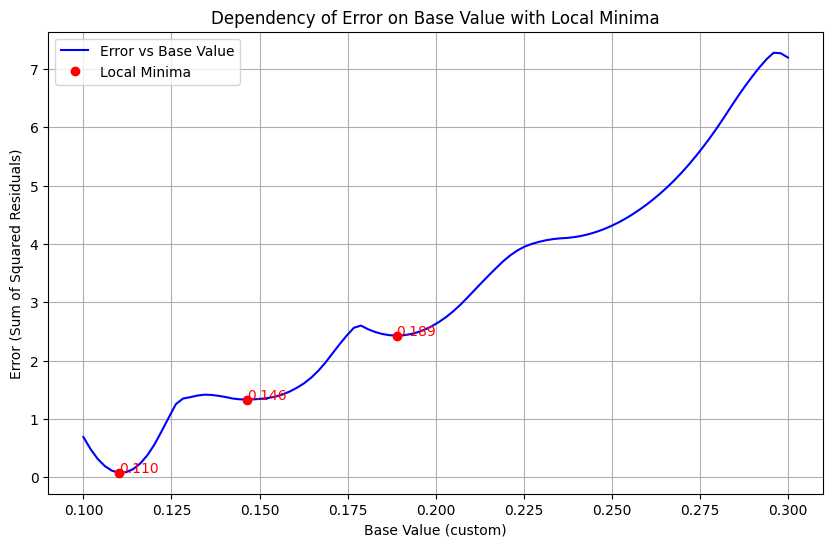

Local minima (base values) and corresponding errors:
Base Value: 0.11010, Error: 0.07895
Base Value: 0.14646, Error: 1.33374
Base Value: 0.18889, Error: 2.42939


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

iois = np.diff(combined_onsets['onset_times'].values)

# Example data (replace with actual data)
data = iois

# Define a range of base values to explore
base_values = np.linspace(0.1, 0.3, 100)  # Adjust range if needed

# Initialize an empty list to store the errors
errors = []

# Loop through different base values and compute the error for each
for base_value_custom in base_values:
    # Calculate multipliers and reconstructed data
    multipliers = np.round(data / base_value_custom)
    reconstructed_data = base_value_custom * multipliers

    # Calculate the residuals and error (sum of squared residuals)
    residuals = data - reconstructed_data
    error = np.sum(residuals**2)

    # Append the error to the list
    errors.append(error)

# Convert errors to a numpy array for further processing
errors = np.array(errors)

# Find local minima (by finding peaks of the negative error array)
minima_indices, _ = find_peaks(-errors)

# Plotting the dependency of the error on the base_value_custom
plt.figure(figsize=(10, 6))
plt.plot(base_values, errors, label='Error vs Base Value', color='blue')

# Mark the local minima
plt.plot(base_values[minima_indices], errors[minima_indices], 'ro', label='Local Minima')

# Annotate the local minima on the plot
for idx in minima_indices:
    plt.text(base_values[idx], errors[idx], f'{base_values[idx]:.3f}', color='red')

plt.title('Dependency of Error on Base Value with Local Minima')
plt.xlabel('Base Value (custom)')
plt.ylabel('Error (Sum of Squared Residuals)')
plt.grid(True)
plt.legend()
plt.show()

# Print out the local minima values
print("Local minima (base values) and corresponding errors:")
for idx in minima_indices:
    print(f"Base Value: {base_values[idx]:.5f}, Error: {errors[idx]:.5f}")


Best base value: 0.110611
Minimum error (sum of squared residuals): 0.077025

Detailed Fit Results:


,Original IOI,Multiplier,Reconstructed IOI,Residual
0,0.105,1,0.110611,-0.005611
1,0.445,4,0.442442,0.002558
2,0.007,0,0.000000,0.007000
3,0.438,4,0.442442,-0.004442
4,0.118,1,0.110611,0.007389
...,...,...,...,...
808,0.243,2,0.221221,0.021779
809,0.313,3,0.331832,-0.018832
810,0.132,1,0.110611,0.021389
811,0.424,4,0.442442,-0.018442


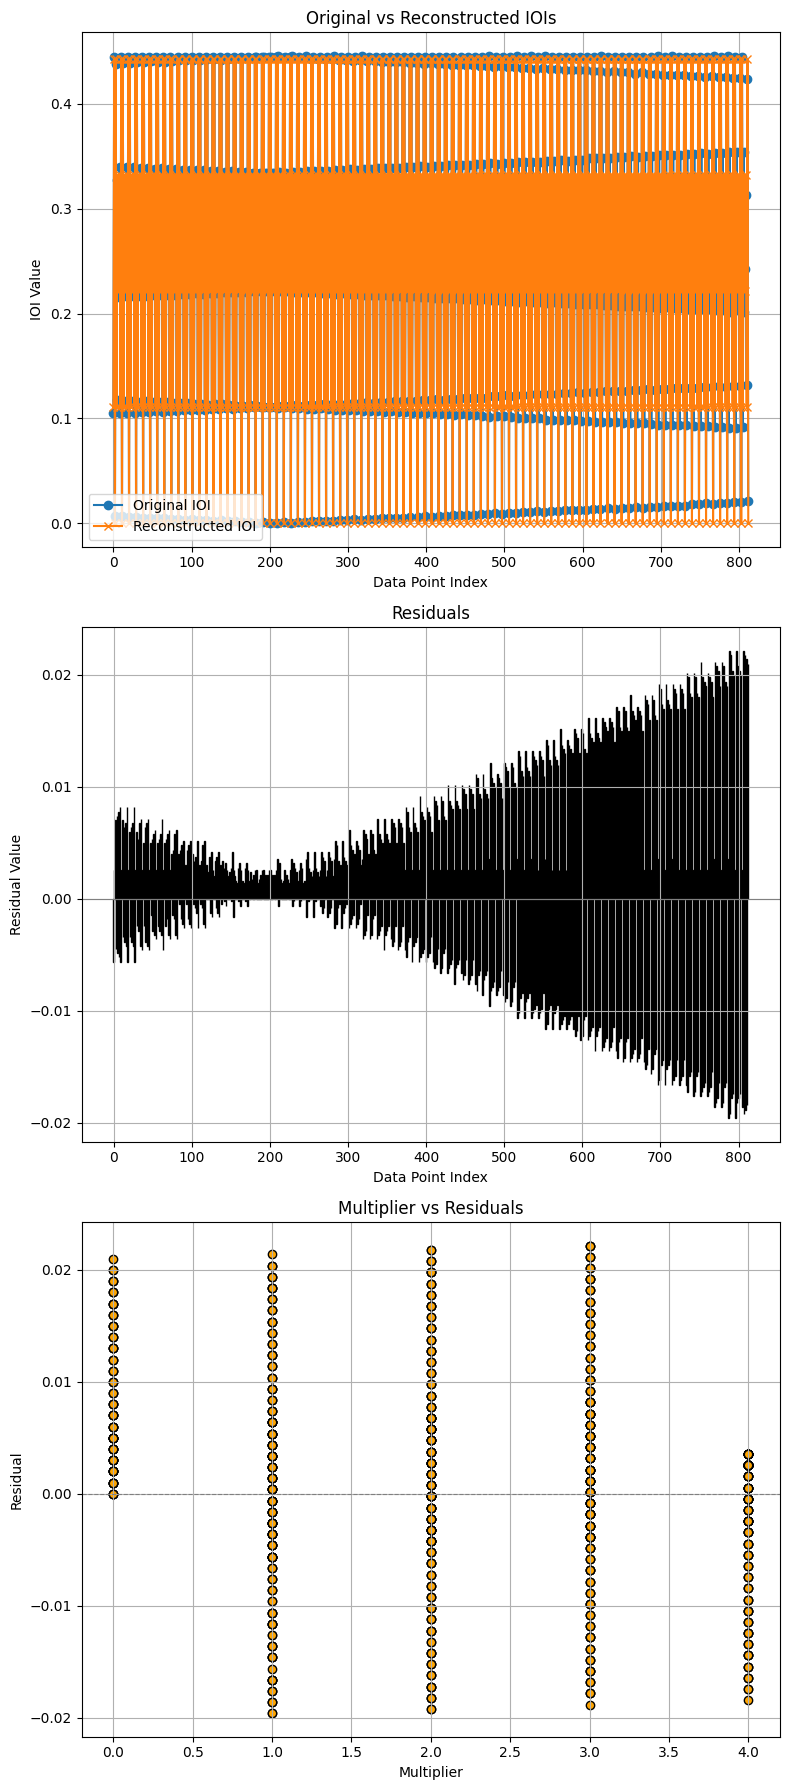

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Replace the following line with your actual 'iois' data
data = iois

# Define the range for the base value
base_value_range = np.linspace(0.1, 0.3, 1000)
best_base_value = 0.1101
min_error = float('inf')

# Grid search for best base value
for base_value in base_value_range:
    multipliers = np.round(data / base_value)
    reconstructed_data = base_value * multipliers
    residuals = data - reconstructed_data
    error = np.sum(residuals**2)

    if error < min_error:
        min_error = error
        best_base_value = base_value

print(f"Best base value: {best_base_value:.6f}")
print(f"Minimum error (sum of squared residuals): {min_error:.6f}")

# Calculate multipliers and reconstructed data using the best base value
multipliers = np.round(data / best_base_value)
reconstructed_data = best_base_value * multipliers
residuals = data - reconstructed_data

# Create a DataFrame to display the results
df = pd.DataFrame({
    'Original IOI': data,
    'Multiplier': multipliers.astype(int),
    'Reconstructed IOI': reconstructed_data,
    'Residual': residuals
})

# Display the DataFrame
print("\nDetailed Fit Results:")
display(df)

# Plotting Original vs Reconstructed IOIs and other subplots
plt.figure(figsize=(8, 18))  # Adjust figure size for vertical alignment

# Subplot 1: Original vs Reconstructed IOIs
plt.subplot(3, 1, 1)
plt.plot(data, label='Original IOI', marker='o')
plt.plot(reconstructed_data, label='Reconstructed IOI', marker='x')
plt.title('Original vs Reconstructed IOIs')
plt.xlabel('Data Point Index')
plt.ylabel('IOI Value')
plt.legend()
plt.grid(True)

# Subplot 2: Residuals
plt.subplot(3, 1, 2)
plt.bar(range(len(residuals)), residuals, color='orange', edgecolor='black')
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Residuals')
plt.xlabel('Data Point Index')
plt.ylabel('Residual Value')
plt.grid(True)

# Subplot 3: Multiplier vs Residuals
plt.subplot(3, 1, 3)
plt.scatter(df['Multiplier'], df['Residual'], color='orange', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Adding a line at y=0 for reference
plt.title('Multiplier vs Residuals')
plt.xlabel('Multiplier')
plt.ylabel('Residual')
plt.grid(True)

plt.tight_layout()
plt.show()